In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import recharge_funcs as rf
import baseflow
from pathlib import Path
import sys
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#Scalable, Normalize
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#segoe UI
plt.rcParams['font.family'] = 'Segoe UI'

#### Model Evaluation
Seasonal comparison of discharge and baseflow

In [140]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]

#station coordinates
station_locations = pd.read_csv("mHM_eval_stations.csv")
#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

#rivers
rivers_shp = gpd.read_file(r"W:/VUB/_main_research/data/shapefiles/HydroRIVERS_v10_eu_shp/HydroRIVERS_v10_eu_shp/hydroRivers_BE.shp")

#Open picked flow data for evaluation stations
with open("eval_stations_Q.pickle", "rb") as f:
    eval_Obs = pickle.load(f)

#read validation stations (NSE>0) #from the flow_validation notebook
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Canals to be removed
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

#Extract only stations in val_gdf
eval_Obs = {k: v for k, v in eval_Obs.items() if k in val_gdf['name'].values}

# Remove canal stations
eval_Obs = {k: v for k, v in eval_Obs.items() if k not in canals}

seasons = ['DJF', 'MAM', 'JJA', 'SON']

season_map = {12:"DJF",1:"DJF",2:"DJF",
            3:"MAM",4:"MAM",5:"MAM",
            6:"JJA",7:"JJA",8:"JJA",
            9:"SON",10:"SON",11:"SON"}

scenarios = ['historical', 'ssp370', 'ssp585']

##### Seasonal comparison of per-station Q

In [3]:
base_sim_dir = "./isimip_Q"
sim_subfolder = "Qrouted"

#Extract and seasonalize total discharge
# model_seasons_df = rf.seasonal_Q_comparison(base_sim_dir, sim_subfolder, models, eval_Obs, season_map)


In [4]:
#extract multistation baseflow
baseflow_models, all_models_BFI, best_method = rf.extract_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs)

Extracting baseflow for ZOUTLEEUW_KLEINE GETE                                                

In [5]:
ensemble_bfi = pd.concat(
        [df.set_index('name') for df in all_models_BFI.values()],
        axis=0
    )

In [18]:
#seasonalize baseflow
Q_names = ['obs_Qb', 'sim_Qb'] #correspond to headers in baseflow_models
seasonal_bf = seasonal_baseflow_analysis(baseflow_models, models, season_map, Q_names)

##### Comparison scatterplots

In [19]:
# rf.plot_multimodel_spread(model_seasons_df, seasons,
#                        "q_obs", 'q_model',
#                        xlabel="Observed seasonal flow",
#                        ylabel="Simulated seasonal flow")

In [20]:
# rf.plot_multimodel_spread(seasonal_bf, seasons,
#                        'obs_Qb', 'sim_Qb',
#                        xlabel="Observed seasonal baseflow",
#                        ylabel="Simulated seasonal baseflow")

In [27]:
ensemble_bfi_df=rf.ensemble_station_BFI(all_models_BFI, 'sim_bfi')

In [28]:
obs_BFI_df=all_models_BFI['GFDL-ESM4']
bfi_diff_gdf = rf.ensemble_BFI_to_geodataframe(ensemble_bfi_df, obs_BFI_df,station_locations)

In [29]:
m_diff, pw = rf.wilcoxon_stats(bfi_diff_gdf)

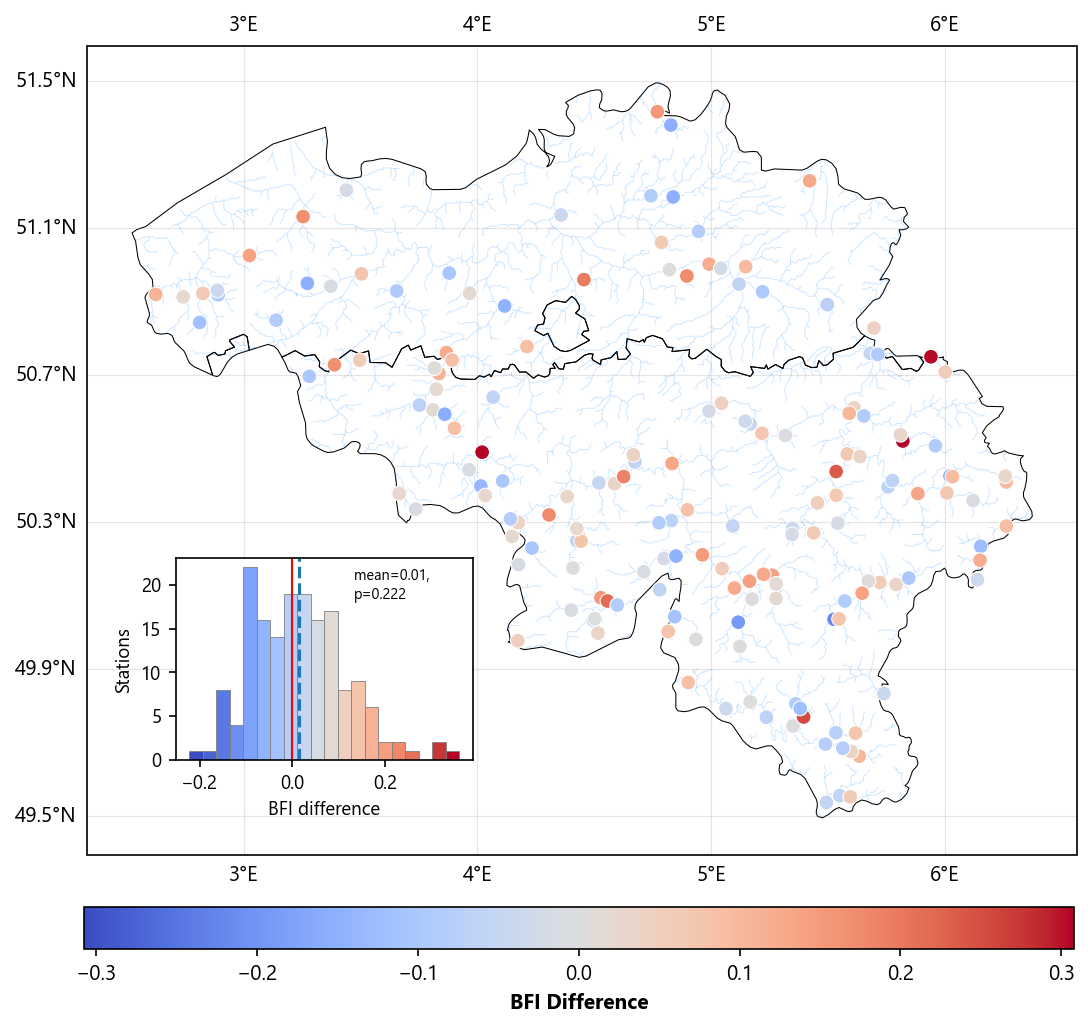

In [ ]:
#Difference between observed and simulated BFI
rf.map_BFI_anomalies(bfi_diff_gdf, be_shp, rivers_shp, m_diff, pw)


_____
_____

#### Projected changes

In [741]:
def extract_scenario_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs, best_bfi_method_dict):
    """  
    Extract baseflow time series for each station and model using the best method based on observed data.  
    Parameters  
    ----------
    base_sim_dir : str  
        Base directory containing model subdirectories.  
    sim_subfolder : str  
        Subfolder within each model directory containing simulation CSV files.  
    models : list of str  
        List of model names corresponding to subdirectory names.  
    eval_Obs : dict   
        Dictionary of observed discharge time series (keyed by station name).  
    best_bfi_method_dict: dict  
        Dictionary containing best baseflow extraction method per station, based on observed data.  
 
    Returns  
    -------
    dict of pd.DataFrame  
        Dictionary with model names as keys and DataFrames with baseflow time series as values.  
    """
    # Ensure station names are uppercase for consistency
    eval_Obs_upper = rf.keys_upper(eval_Obs)

    all_models_Qb = []
    all_models_BFI = {}

    for model in models:
        print(f'\nExtracting baseflow for {model}...')
        sim_dir = Path(base_sim_dir) / model / sim_subfolder
        stations_Qb = []
        stations_BFI = []

        for fpath in sorted(sim_dir.glob("*.csv")):
            station_name = fpath.stem.upper()

            if station_name not in eval_Obs_upper:
                continue

            sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

            #select best method based on observed baseflow separation
            if station_name not in best_bfi_method_dict:
                continue

            bfi_method=best_bfi_method_dict[station_name]

            #extract baseflow
            msg = f"Extracting baseflow for {station_name}"
            sys.stdout.write("\r" + msg + "  " * 20)
            sys.stdout.flush()

            #use the same best method to extract the baseflow from the simulated Q
            sim_bf_dict, sim_bfi = baseflow.separation(sim_Q, return_bfi=True, return_kge=False, method=bfi_method)
            sim_Qb= sim_bf_dict[bfi_method]
            sim_bfi = sim_bfi[bfi_method]

            sim_Qb.columns = ['sim_Qb']
            sim_Qb['station'] = station_name
            sim_Qb['Q_total'] = sim_Q['Qrouted']
            
            #rearrange columns
            sim_Qb=sim_Qb[["station", 'sim_Qb', 'Q_total']]
            stations_Qb.append(sim_Qb)

            #bfi data
            sim_bfi_df=pd.DataFrame({"sim_bfi":sim_bfi.values})
            sim_bfi_df['name'] = station_name
            sim_bfi_df['model'] = model

            sim_bfi_df=sim_bfi_df[["name","sim_bfi", "model"]]
            stations_BFI.append(sim_bfi_df)

        if stations_Qb:
            model_bf_df = pd.concat(stations_Qb)
            model_bf_df['model'] = model
            all_models_Qb.append(model_bf_df)
        
        if stations_BFI:
            model_bfi_df = pd.concat(stations_BFI)
            model_bfi_df['model'] = model
            # Optionally store BFI data if needed
            all_models_BFI[model] = model_bfi_df
            
    all_models_Qb = pd.concat(all_models_Qb,axis=0)

    return all_models_Qb, all_models_BFI

In [737]:
def seasonal_baseflow_analysis(all_models_Qb, models, season_map, Q_names):
    """  
    Analyze seasonal mean baseflow for each station and model.  
    Parameters  
    ----------
    all_models_Qb : pd.DataFrame  of models and station baseflow
        DataFrame with total flow and baseflow time series for each model and station.
    models : list of str
        List of model names corresponding to keys in all_models_Qb.
    season_map : dict
        Mapping of month numbers to season labels.  
    Q_names: list  
        Name of discharge to groupby e.g. ["obs_Qb","sim_Qb"]

    Returns  
    -------
    pd.DataFrame  
        DataFrame with columns ['name', 'model', 'season', 'obs_Qb', 'sim_Qb'] containing seasonal mean baseflow.  
    """

    seasonal_baseflow = []

    # Initialize a dictionary to hold seasonal data for the station
    for model in models:
        model_df = all_models_Qb[all_models_Qb['model'] == model]

        stations_Qb = []  # <-- collect per model

        for nameStation in model_df['station'].unique():

            station_df = model_df[model_df['station'] == nameStation]
            
            station_df = station_df.copy()
            station_df["season"] = station_df.index.month.map(season_map)

            # seasonal climatology
            season_Qb = station_df.groupby("season")[Q_names].mean().reset_index()
            season_Qb["name"] = nameStation
            season_Qb["model"] = model
            stations_Qb.append(season_Qb)
        
        if stations_Qb:  # <-- use the correct list
            model_Qb_df = pd.concat(stations_Qb)
            seasonal_baseflow.append(model_Qb_df)
        
    #convert to dataframe
    seasonal_baseflow_df = pd.concat(seasonal_baseflow)
    #rearrange columns
    seasonal_baseflow_df = seasonal_baseflow_df[["name", "model", "season"] + Q_names]

    return seasonal_baseflow_df

In [1195]:
#Calculate multimodel ensemble BFI mean
def ensemble_station_BFI(all_models_BFI, sim_name):
    """  
    Concatenate simulated BFI from multiple model dictionaries
    ----------
    Parameters:
    all_model_BFI: dict  
    Dictionary containing individual model station dataframes of BFI, indexed by model name
    smi_name: str
    name of simulate Q variable

    ----------
    Returns:  
    df: ensemble average dataframe of average per station BFI
    """
    # Combine all model BFIs by 'name'
    ensemble_bfi = pd.concat(
        [df.set_index('name')[sim_name] for df in all_models_BFI.values()],
        axis=1
    )

    # Compute mean across models
    ensemble_bfi_mean = ensemble_bfi.mean(axis=1, skipna=True)

    # Convert to final DataFrame
    ensemble_bfi_df = ensemble_bfi_mean.reset_index()
    ensemble_bfi_df.columns = ['name', 'ens_BFI']

    return ensemble_bfi_df

#======================================================================
def df_to_gdf(df, stations_df):
    """ Convert dataframe to geodataframe by combining with df with station coordinates"""
    #change station_locations to upper
    stations_df['name'] = stations_df['name'].str.upper()

    #only unique station names
    station_locations_df = stations_df.drop_duplicates(subset='name').set_index('name')

    #merge station_locations with df on 'name'
    ensemble_stations = pd.concat([station_locations_df, df], axis=1).dropna()

    #to geodataframe
    gdf_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(ensemble_stations['lon'], ensemble_stations['lat']))
    gdf_.crs = "EPSG:4326"

    return gdf_

#======================================================================
#seasonal BFI per model and station
def extract_seasonal_BFI(scenario_BF_models, models, season_map):
    """  
    Analyze seasonal mean BFI for each station and model.  
    Parameters  
    ----------
    scenario_BF_models : pd.DataFrame  of models and station baseflow
        Dataframe with model names, Q_total and sim_Qb time series for each model and station 
    models : list of str  
        List of model names corresponding to keys in scenario_BF_models.  
    season_map : dict
        Mapping of month numbers to season labels.  

    Returns  
    -------
    pd.DataFrame  
        DataFrame with columns ['name', 'model', 'season', 'BFI'] containing seasonal mean BFI.  
    """         
    models_seasonal_BFI = []
    for model in models:
        sim_Q_model = scenario_BF_models[scenario_BF_models['model'] == model].copy()
        #map seasons
        sim_Q_model['season'] = sim_Q_model.index.month.map(season_map)

        # Seasonal sums per station
        aggregated_flow = sim_Q_model.groupby(['station','season'])[['sim_Qb','Q_total']].sum().reset_index()

        # Calculate BFI, handling division by zero
        aggregated_flow['BFI'] = np.divide(aggregated_flow['sim_Qb'].to_numpy(),
                                    aggregated_flow['Q_total'].to_numpy(),
                                    out=np.zeros(len(aggregated_flow), dtype=float),
                                    where=aggregated_flow['Q_total'].to_numpy() != 0)

        model_seasonal_BFI = (aggregated_flow
        .pivot(index='station', columns='season', values='BFI')
        .reindex(columns=['DJF','MAM','JJA','SON'])
        .rename_axis(None, axis=1)
        .reset_index()
        .rename(columns={'station':'name'})
        )
        model_seasonal_BFI['model'] = model
        models_seasonal_BFI.append(model_seasonal_BFI)

    model_seasonal_BFI = pd.concat(models_seasonal_BFI)

    return model_seasonal_BFI

def seasonalize_baseflow(all_models_Qb, season_map=None, Q_names=("sim_Qb")):

    Q_names = list(Q_names)
    df = all_models_Qb.copy()

    df['season'] = df.index.month.map(season_map)

    bf_season_mean = (pd.pivot_table(df, values=Q_names,
                           index=['model','station'],
                           columns='season',
                           aggfunc='mean', observed=True)
              .reindex() 
            )
    bf_season_mean = bf_season_mean.reset_index().rename(columns={'station': 'name'})
    season_list = bf_season_mean.columns.get_level_values(1).to_list()
    bf_season_mean.columns = ['model', 'name'] + season_list[2:]
    return bf_season_mean

In [1193]:
Q_names = list(Q_names)
df = scenario_BF_models.copy()

df['season'] = df.index.month.map(season_map)

bf_season_mean = (pd.pivot_table(df, values=Q_names,
                        index=['model','station'],
                        columns='season',
                        aggfunc='mean', observed=True)
            .reindex() 
        )
bf_season_mean = bf_season_mean.reset_index().rename(columns={'station': 'name'})
season_list = bf_season_mean.columns.get_level_values(1).to_list()
bf_season_mean.columns = ['model', 'name'] + season_list[2:]


##### Extract seasonal flow for future scenarios

In [ ]:
Q_names=['sim_Qb']

baseflow_scenarios = {}
bfi_scenarios={}
seasonal_BFI={}
#changes in baseflow under respective scenarios
for scenario in scenarios:
    base_sim_dir = f"./isimip_Q/{scenario}"
    sim_subfolder = "Qrouted"

    #Extract and seasonalize total discharge
    print(f"\nextracting baseflow for {scenario}")
    scenario_BF_models, all_models_BFI = extract_scenario_multistation_baseflow(base_sim_dir, sim_subfolder, models, eval_Obs, best_method)
    
    #seasonal BF totals
    print(f"\nseasonal BFI for {scenario}")
    seasonal_bf=seasonalize_baseflow(scenario_BF_models, season_map, Q_names)
    baseflow_scenarios[scenario] = seasonal_bf

    #seasonal BFI per model and station
    print(f"\n Extracting seasonal BFI for {scenario}")
    seasonal_bfi_per_model = extract_seasonal_BFI(scenario_BF_models, models, season_map)

    seasonal_BFI[scenario]=seasonal_bfi_per_model
    
    #compute ensemble BFI for the scenario
    ensemble_scenario_bfi = pd.concat(
        [df.set_index('name') for df in all_models_BFI.values()],
        axis=0
    )
    ensemble_scenario_bfi['scenario'] = scenario
    bfi_scenarios[scenario] = ensemble_scenario_bfi

##### Compute Projected changes under CC

Projected changes in annual Baseflow

In [1197]:
#annual projected baseflow changes
bf_delta_gdf={}

future_scenarios = ['ssp370', 'ssp585']
hist_bf_df=baseflow_scenarios['historical'].groupby('name').mean(numeric_only=True)
for scenario in future_scenarios:
    scenario_df=baseflow_scenarios[scenario].groupby('name').mean(numeric_only=True)
    bf_change_df= 100 * (scenario_df - hist_bf_df)/hist_bf_df
    
    #convert to gdf for mapping
    bf_change_gdf = df_to_gdf(bf_change_df, station_locations)
    bf_delta_gdf[scenario] = bf_change_gdf

##### Seasonal Baseflow

In [1198]:
#Seasonal projected baseflow changes
bf_seasonal_delta_gdf={}

hist_seasonal_bf_df=baseflow_scenarios['historical'].groupby(['name']).mean(numeric_only=True)
for scenario in future_scenarios:
    bf_per_season = []
    scenario_df = baseflow_scenarios[scenario].groupby(['name']).mean(numeric_only=True)
    seasonal_delta = 100 * (scenario_df - hist_seasonal_bf_df) / hist_seasonal_bf_df
    df = seasonal_delta
    #convert to gdf for mapping
    seasonal_change_gdf = df_to_gdf(df, station_locations)

    #append to dictionary
    bf_seasonal_delta_gdf[scenario] = seasonal_change_gdf

In [1199]:
def map_baseflow_stats(
    bf_gdf, boundaries_shp, streams_shp, bf_var, c_map,
    ax=None, cax=None
):
    """
    Map differences between obs. and sim. BFI per station overlain over a map and river network.
    Returns figure/axes handles so labels can be customized outside.
    """

    # Create fig/ax if not provided
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
        created_fig = True
    else:
        fig = ax.figure

    # Background layers
    boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none',
                        zorder=1, transform=ccrs.PlateCarree())

    streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue',
                     facecolor='none', zorder=2, transform=ccrs.PlateCarree())

    vals = bf_gdf[bf_var].to_numpy()

    # Color: diverging centered at 0 (robust limits)
    p1, p99 = np.nanpercentile(vals, [1, 100])
    vmin, vmax = p1, p99
    
    eps = 1e-6
    if vmax <= 0:  # all data ≤ 0 -> keep a tiny positive headroom
        vmax = eps
    if vmin >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin = -eps

    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    cmap_name = c_map
    cmap = plt.get_cmap(cmap_name)
    sm = ScalarMappable(norm=norm, cmap=cmap)  # single source of truth


    # Size: scale |diff|
    mag = np.abs(vals)
    smin, smax = 30, 100
    if np.nanmax(mag) > np.nanmin(mag):
        sizes = np.interp(mag, [np.nanmin(mag), np.nanmax(mag)], [smin, smax])
    else:
        sizes = np.full_like(mag, (smin + smax) / 2.0)

    sc = ax.scatter(
        bf_gdf.geometry.x,
        bf_gdf.geometry.y,
        c=vals, s=sizes,
        cmap=cmap, norm=norm,
        edgecolor='white', linewidth=0.5,
        transform=ccrs.PlateCarree(), zorder=3,
    )

    # Gridlines
    gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
    gl.top_labels = True
    gl.right_labels = False

    # Inset histogram
    ax_hist = inset_axes(ax, width="30%", height="20%",
                     bbox_to_anchor=(-.60, -.62, 1.0, 1.0),
                     bbox_transform=ax.transAxes)

    # histogram
    counts, bins, patches = ax_hist.hist(vals, bins=20)
    centers = 0.5 * (bins[:-1] + bins[1:])

    # color bars with the SAME mapping as the scatter/colorbar
    for c, p in zip(centers, patches):
        p.set_facecolor(sm.to_rgba(c))
        p.set_edgecolor('gray')
        p.set_linewidth(0.4)

    # reference lines/annotations
    ax_hist.axvline(np.nanmean(vals), linewidth=1)
    ax_hist.axvline(0, lw=0.8, alpha=0.6)
    ax_hist.set_xlim(vmin, vmax)

    # Colorbar: use provided cax or create a default one
    if cax is None:
        # default horizontal colorbar under the map
        cax = fig.add_axes([0.291, 0.02, 0.44, 0.04])
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    cbar.set_label('BFI Difference', fontsize=10, weight='bold')
    cbar.ax.tick_params(labelsize=10)

    # Return handles so caller can customize
    return fig, ax, cbar, ax_hist, sc


In [1200]:
def map_baseflow_stats_multi(
    delta_dict,               # dict[str, GeoDataFrame], e.g. {'ssp370': gdf, 'ssp585': gdf}
    boundaries_shp,           # GeoDataFrame for boundaries
    streams_shp,              # GeoDataFrame for rivers/streams
    bf_var='sim_Qb',          # column with values to plot
    c_map='plasma',           # matplotlib colormap name
    ncols=2,                  # number of columns in subplot grid
    figsize=(16, 8),          # figure size
    dpi=150,
    show_hist=True,           # show per-panel inset histogram
    gridlines=True,           # draw gridlines
):
    """
    Faceted maps for multiple baseflow-delta GeoDataFrames with shared colorbar.
    Returns: fig, axes_dict, cbar, hist_axes_dict, scatters_dict
    """
    # --- gather all values to set a shared norm/size scale ---
    scenarios = list(delta_dict.keys())
    all_vals = np.concatenate([
        np.asarray(delta_dict[k][bf_var].to_numpy(), dtype=float) for k in scenarios
        if bf_var in delta_dict[k].columns
    ])
    # robust limits
    p1, p99 = np.nanpercentile(all_vals, [1, 99])
    vmin, vmax = p1, p99

    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(c_map)
    sm = ScalarMappable(norm=norm, cmap=cmap) 

    # --- layout ---
    n = len(scenarios)
    ncols = max(1, ncols)
    nrows = int(np.ceil(n / ncols))

    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])
    axs = axs.reshape(nrows, ncols)

    axes_dict = {}
    scatters_dict = {}
    hist_axes_dict = {}

    # --- draw each panel ---
    for i, scenario in enumerate(scenarios):
        r, c = divmod(i, ncols)
        ax = axs[r, c]
        axes_dict[scenario] = ax

        gdf = delta_dict[scenario]
        vals = gdf[bf_var].to_numpy()

        # background
        boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none',
                            zorder=1, transform=ccrs.PlateCarree())
        streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue',
                         facecolor='none', zorder=2, transform=ccrs.PlateCarree())

        sc = ax.scatter(
            gdf.geometry.x, gdf.geometry.y,
            c=vals, s=80, cmap=cmap, norm=norm,
            edgecolor='white', linewidth=0.5,
            transform=ccrs.PlateCarree(), zorder=3
        )
        scatters_dict[scenario] = sc

        if gridlines:
            gl = ax.gridlines(draw_labels=False, color='gray', lw=0.6, alpha=0.2)
            gl.bottom_labels = True
            #add left gridlines to the left column
            if c == 0:
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = True
           


        ax.set_title(scenario, fontsize=12, weight='bold')

        # inset histogram
        if show_hist:
            ax_hist = inset_axes(ax, width="28%", height="20%",
                                 bbox_to_anchor=(-.58, -.60, 1.0, 1.0),
                                 bbox_transform=ax.transAxes)
            counts, bins, patches = ax_hist.hist(vals, bins=20)
            centers = 0.5*(bins[:-1] + bins[1:])
            for cval, patch in zip(centers, patches):
                patch.set_facecolor(sm.to_rgba(cval))
                patch.set_edgecolor('gray')
                patch.set_linewidth(0.4)
            ax_hist.axvline(np.nanmean(vals), linewidth=1)
            ax_hist.axvline(0, lw=0.8, alpha=0.6)
            ax_hist.set_xlim(vmin, vmax)
            ax_hist.set_xlabel("BF change (%)", fontsize=9)
            ax_hist.tick_params(axis='both', labelsize=8)
            hist_axes_dict[scenario] = ax_hist

    # hide any unused axes (if grid not filled)
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axs[r, c].set_visible(False)

    # shared colorbar
    cax = fig.add_axes([0.92, 0.11, 0.02, 0.80]) #left, bottom, width, height
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cbar.set_label('Projected change in BF (%)', fontsize=12, weight='bold')
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.98])
    return fig, axes_dict, cbar, hist_axes_dict, scatters_dict


In [ ]:
fig, axes_dict, cbar, hist_axes, scatters = map_baseflow_stats_multi(
    bf_delta_gdf,        # your dict: {'ssp370': gdf, 'ssp585': gdf}
    be_shp, rivers_shp,
    bf_var='sim_Qb',
    c_map='PuRd_r',
    ncols=2,
    figsize=(12, 8)
)

# Optional: tweak global labels afterwards
cbar.set_label('Projected change in BF (%)', fontsize=12)
for scen, ax in axes_dict.items():
    ax.set_title(f"{scen.upper()}", fontsize=12)

plt.show()


In [ ]:
def map_baseflow_stats_seasonal(
    seasonal_delta_dict,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    boundaries_shp,           # GeoDataFrame boundaries
    streams_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='RdBu_r',           # diverging colormap suits +/- changes
    point_size=50,            # constant marker size
    figsize=(12, 8),
    dpi=150,
    gridlines=True,
    show_hist=True
):
    """
    2x4 seasonal maps. Row 0 = first scenario, Row 1 = second scenario.
    Expects each GDF in seasonal_delta_dict to have one column per season.
    Returns: fig, axes (2D array), cbar
    """
    # ---- gather global value range across scenarios & seasons ----
    all_vals = []
    for scen in scenarios:
        gdf = seasonal_delta_dict[scen]
        for seas in seasons:
            if seas in gdf.columns:
                all_vals.append(gdf[seas].to_numpy(dtype=float))
    all_vals = np.concatenate(all_vals) if all_vals else np.array([0.0])

    # keep 0 strictly inside the range for TwoSlopeNorm
    finite = all_vals[np.isfinite(all_vals)]
    vmin_g = float(np.nanmin(finite)) if finite.size else -1.0
    vmax_g = float(np.nanmax(finite)) if finite.size else  1.0
    eps = max(1e-9, (vmax_g - vmin_g) * 1e-6)

    # Use TwoSlopeNorm centered at 0 if values straddle 0; otherwise fall back to Normalize
    if vmin_g < 0 < vmax_g:
        vmin, vmax = vmin_g, vmax_g
    elif vmin_g >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin, vmax = 0 - eps, vmax_g
    else:
        vmin, vmax = vmin_g, vmax_g
  
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(c_map)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # ---- layout ----
    nrows, ncols = 2, 4
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # column titles = seasons
    for j, seas in enumerate(seasons):
        axs[0, j].set_title(seas, fontsize=12, weight='bold')

    # row labels = scenarios
    axs[0,0].text(-0.18, 0.5, scenarios[0].upper(), va='center', ha='right',
                  rotation=90, transform=axs[0,0].transAxes, fontsize=12, weight='bold')
    axs[1,0].text(-0.18, 0.5, scenarios[1].upper(), va='center', ha='right',
                  rotation=90, transform=axs[1,0].transAxes, fontsize=12, weight='bold')

    # ---- draw panels ----
    for i, scen in enumerate(scenarios):
        gdf_all = seasonal_delta_dict[scen]
        xs = gdf_all.geometry.x
        ys = gdf_all.geometry.y

        for j, seas in enumerate(seasons):
            ax = axs[i, j]
            vals = gdf_all[seas].to_numpy(dtype=float)

            # background layers
            boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none',
                                zorder=1)
            streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue',
                             facecolor='none', zorder=2)

            # points (color encodes seasonal value)
            ax.scatter(
                xs, ys,
                c=vals, s=point_size,
                cmap=cmap, norm=norm,
                edgecolor='white', linewidth=0.5,
                transform=ccrs.PlateCarree(), zorder=3
            )
            #frame
            # Turn frame on (draw spines)
            ax.set_frame_on(True)

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)


            if gridlines:
                gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = (j == 0)         # only left column
                gl.bottom_labels = (i == nrows-1) # only bottom row
                #gridline spacing
                gl.ylocator = mpl.ticker.FixedLocator(np.arange(49, 52.1, 0.5))

            if show_hist:
                ax_hist = inset_axes(ax, width="25%", height="20%",
                                     bbox_to_anchor=(-.57, -.58, 1.0, 1.0),
                                     bbox_transform=ax.transAxes)
                data = vals[np.isfinite(vals)]
                counts, bins, patches = ax_hist.hist(data, bins=10)
                centers = 0.5 * (bins[:-1] + bins[1:])
                for cval, patch in zip(centers, patches):
                    patch.set_facecolor(sm.to_rgba(cval))
                    patch.set_edgecolor('gray')
                    patch.set_linewidth(0.4)
                m = np.nanmean(data) if data.size else np.nan
                ax_hist.axvline(m, linewidth=0.9,c='k')
                ax_hist.text(0.35, 1.50, f"{np.round(m,1)}%", transform=ax_hist.transAxes,
                             ha='right', va='top', fontsize=10, weight='bold', color='green')
                ax_hist.set_xlim(norm.vmin, norm.vmax)
                ax_hist.set_xlabel("ΔBF (%)", fontsize=9)
                ax_hist.set_ylabel("Stations", fontsize=7)
                ax_hist.tick_params(axis='both', labelsize=8)
                ax_hist.grid(alpha=0.3)

    # ---- shared colorbar ----
    cax = fig.add_axes([1.0, 0.095, 0.02, 0.80]) #left, bottom, width, height
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cbar.set_label('Projected change in BF (%)', fontsize=14)
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout()
    return fig, axs, cbar

C:\Users\kart\AppData\Local\Temp\ipykernel_19300\2467525365.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


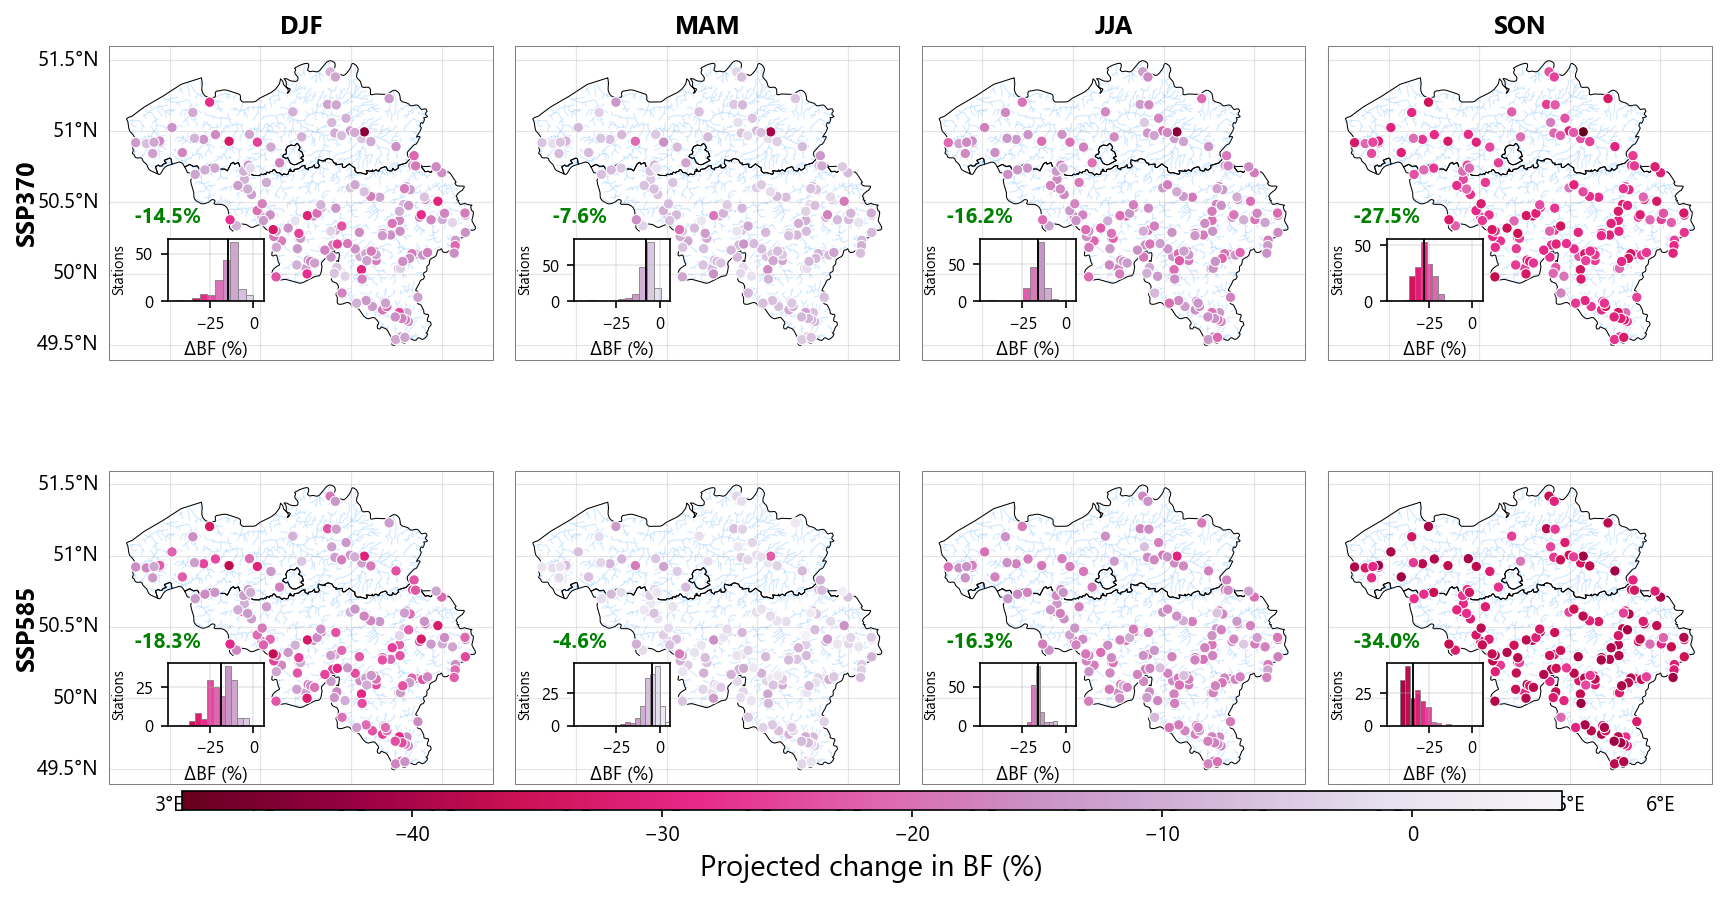

In [1408]:

fig, axs, cbar = map_baseflow_stats_seasonal(
    bf_seasonal_delta_gdf,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    be_shp,           # GeoDataFrame boundaries
    rivers_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='PuRd_r',           # diverging colormap suits +/- changes
    point_size=25,            # constant marker size
    figsize=(11.5, 6.5),
    dpi=150,
    gridlines=True,
    show_hist=True
)
plt.show()

In [1429]:

def map_baseflow_stats_seasonal(
    seasonal_delta_dict,      # {'ssp370': gdf, 'ssp585': gdf} with ['name','DJF','MAM','JJA','SON','geometry']
    boundaries_shp,
    streams_shp,
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='RdBu_r',
    point_size=50,
    figsize=(12, 8),
    dpi=150,
    gridlines=True,
    show_hist=True
):
# ---- gather global value range across scenarios & seasons ----
    all_vals = []
    for scen in scenarios:
        gdf = seasonal_delta_dict[scen]
        for seas in seasons:
            if seas in gdf.columns:
                all_vals.append(gdf[seas].to_numpy(dtype=float))
    all_vals = np.concatenate(all_vals) if all_vals else np.array([0.0])

    # keep 0 strictly inside the range for TwoSlopeNorm
    finite = all_vals[np.isfinite(all_vals)]
    vmin_g = float(np.nanmin(finite)) if finite.size else -1.0
    vmax_g = float(np.nanmax(finite)) if finite.size else  1.0
    eps = max(1e-9, (vmax_g - vmin_g) * 1e-6)

    # Use TwoSlopeNorm centered at 0 if values straddle 0; otherwise fall back to Normalize
    if vmin_g < 0 < vmax_g:
        vmin, vmax = vmin_g, vmax_g
    elif vmin_g >= 0:  # all data ≥ 0 -> keep a tiny negative headroom
        vmin, vmax = 0 - eps, vmax_g
    else:
        vmin, vmax = vmin_g, vmax_g
  
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(c_map)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    # ---- layout: seasons as rows, scenarios as cols ----
    nrows, ncols = len(seasons), len(scenarios)
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi,
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    axs = np.atleast_2d(axs)

    # column titles = scenarios
    for j, scen in enumerate(scenarios):
        axs[0, j].set_title(scen.upper(), fontsize=12, weight='bold')

    # row labels = seasons
    for i, seas in enumerate(seasons):
        axs[i, 0].text(-0.16, 0.5, seas, va='center', ha='right',
                       rotation=90, transform=axs[i, 0].transAxes,
                       fontsize=12, weight='bold')

    # ---- draw panels ----
    for i, seas in enumerate(seasons):          # rows
        for j, scen in enumerate(scenarios):    # cols
            ax = axs[i, j]
            gdf = seasonal_delta_dict[scen]
            if seas not in gdf.columns:
                ax.set_axis_off(); continue

            xs = gdf.geometry.x
            ys = gdf.geometry.y
            vals = gdf[seas].to_numpy(dtype=float)

            boundaries_shp.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none', zorder=1)
            streams_shp.plot(ax=ax, linewidth=0.5, alpha=0.2, edgecolor='dodgerblue', facecolor='none', zorder=2)

            ax.scatter(xs, ys, c=vals, s=point_size, cmap=cmap, norm=norm,
                       edgecolor='white', linewidth=0.5,
                       transform=ccrs.PlateCarree(), zorder=3)

            if gridlines:
                gl = ax.gridlines(draw_labels=True, color='gray', lw=0.6, alpha=0.2)
                gl.top_labels = False
                gl.right_labels = False
                gl.left_labels = (j == 0)            # only first column
                gl.bottom_labels = (i == nrows - 1)   # only last row
                gl.ylocator = mpl.ticker.FixedLocator(np.arange(49, 52.1, 0.5))
                #labelsize
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}

                #frame
            # Turn frame on (draw spines)
            ax.set_frame_on(True)

            # Loop over all spines (top, bottom, left, right) and set color/width
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)

            if show_hist:
                ax_hist = inset_axes(ax, width="27%", height="20%",
                                     bbox_to_anchor=(-.57, -.60, 1.0, 1.0),
                                     bbox_transform=ax.transAxes)
                data = vals[np.isfinite(vals)]
                counts, bins, patches = ax_hist.hist(data, bins=10)
                centers = 0.5 * (bins[:-1] + bins[1:])
                for cval, patch in zip(centers, patches):
                    patch.set_facecolor(sm.to_rgba(cval))
                    patch.set_edgecolor('gray')
                    patch.set_linewidth(0.4)
                if data.size:
                    m = float(np.nanmean(data))
                    ax_hist.axvline(m, linewidth=0.7,c='k')
                    ax_hist.text(0.35, 1.25, f"{m:.1f}%", transform=ax_hist.transAxes,
                                 ha='right', va='top', fontsize=10, c='dodgerblue', weight='bold')
                ax_hist.set_xlim(norm.vmin, norm.vmax)
                #change figure thickness
                for spine in ax_hist.spines.values():
                    spine.set_edgecolor('gray')
                    spine.set_linewidth(0.5)
                ax_hist.grid(alpha=0.3)
                ax_hist.set_xlabel("BF change (%)", fontsize=8)
                ax_hist.set_ylabel("Stations", fontsize=8)
                ax_hist.tick_params(axis='both', labelsize=6)

    # ---- shared colorbar ----
    cax = fig.add_axes([0.88, 0.08, 0.03, 0.87]) #left, bottom, width, height
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cbar.set_label('Projected change in BF (%)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.98])
    return fig, axs, cbar


C:\Users\kart\AppData\Local\Temp\ipykernel_19300\2918212260.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.98])


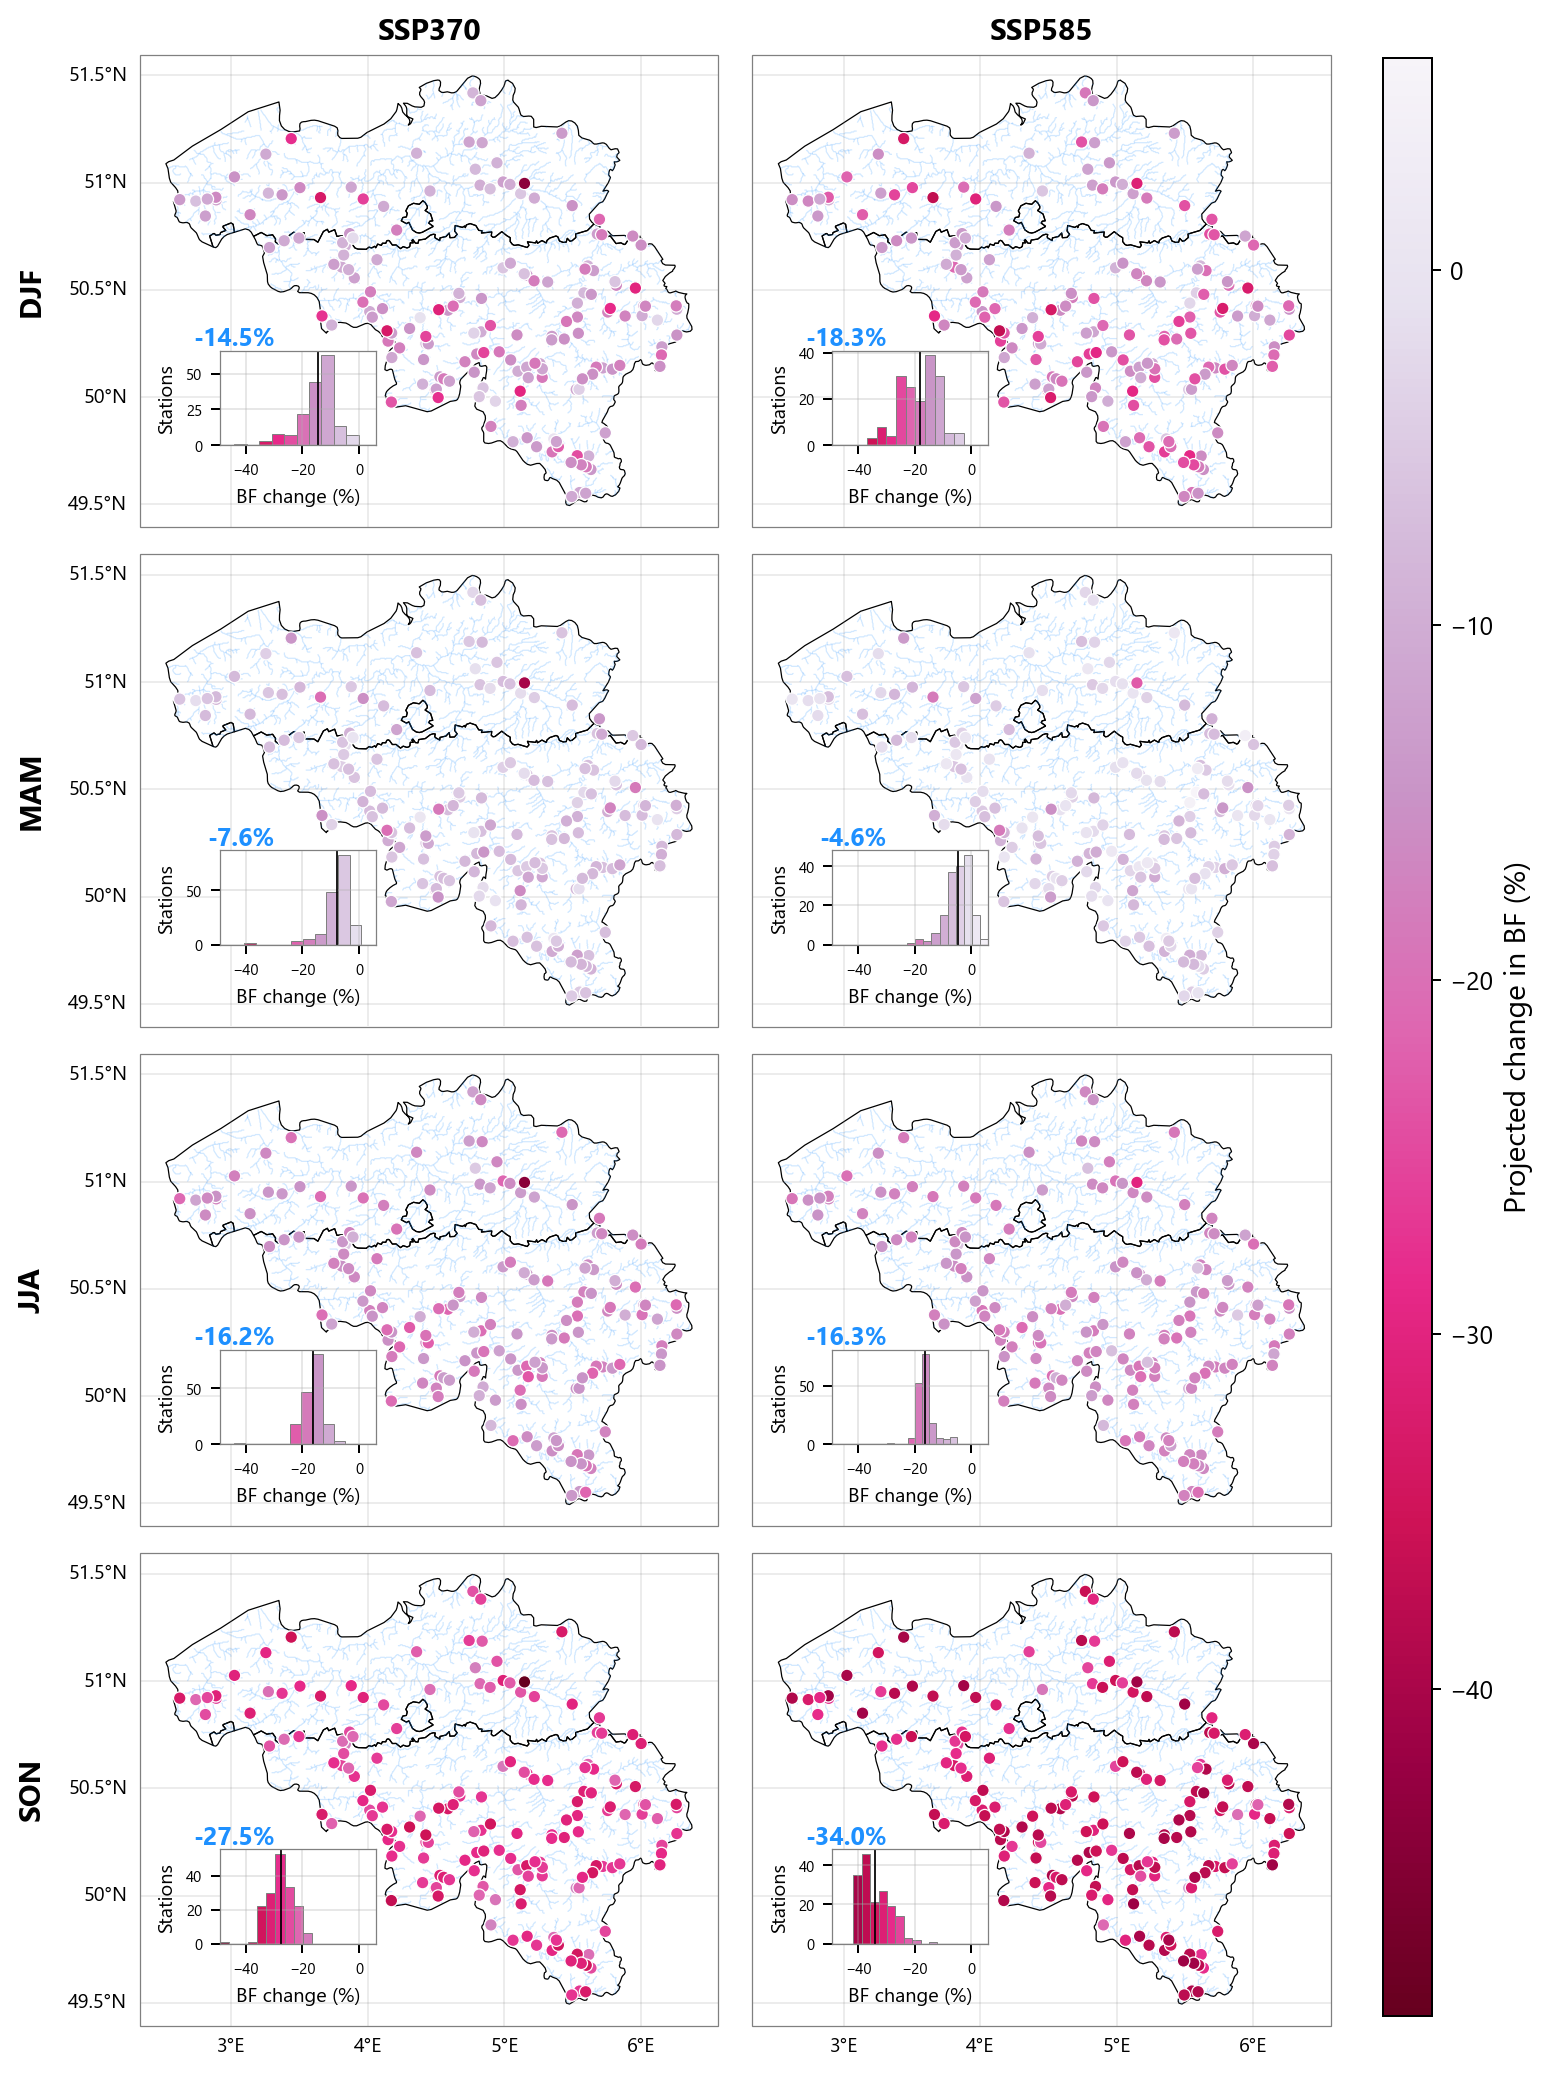

In [1430]:

fig, axs, cbar = map_baseflow_stats_seasonal(
    bf_seasonal_delta_gdf,      # dict[str, GeoDataFrame] with columns: ['name','DJF','MAM','JJA','SON','geometry']
    be_shp,           # GeoDataFrame boundaries
    rivers_shp,              # GeoDataFrame rivers
    scenarios=('ssp370', 'ssp585'),
    seasons=('DJF', 'MAM', 'JJA', 'SON'),
    c_map='PuRd_r',           # diverging colormap suits +/- changes
    point_size=25,            # constant marker size
    figsize=(9.0, 12.5),
    dpi=180,
    gridlines=True,
    show_hist=True
)
plt.show()